In [1]:
import pandas as pd
import numpy as np

import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sb

**train_mfti.parquet** – сырые данные, которые можно использовать для обучения модели

* event_date – дата взаимодейтсвия
* event_timestamp – timestamp взаимодействия в секундах 
* vacancy_id_ - id вакансии, с которой было взаимодействие
* cookie_id – id пользователя по его браузеру/ip/устройству
* user_id – id пользователя на сайте rabota.ru (есть только для зарегистрированных пользователей)
* event_type – тип взаимодействия

In [2]:
# Загружаем датасет

data_folder = 'Data_Rabota'
train_mfti_df = pd.read_parquet(f"{data_folder}/train_mfti.parquet")

In [3]:
train_mfti_df.head()

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy


In [4]:
# Выводим общую информацию, делаем вывод, что есть пропущенные user_id

train_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12292588 entries, 0 to 12292587
Data columns (total 6 columns):
 #   Column           Non-Null Count     Dtype 
---  ------           --------------     ----- 
 0   event_date       12292588 non-null  object
 1   event_timestamp  12292588 non-null  int64 
 2   vacancy_id_      12292588 non-null  int64 
 3   cookie_id        12292588 non-null  object
 4   user_id          8711177 non-null   object
 5   event_type       12292588 non-null  object
dtypes: int64(2), object(4)
memory usage: 562.7+ MB


**Выводим информацию о количестве уникальных значений для всех колонок**

In [5]:
print(f"nUnique vacancy_id_: {train_mfti_df['vacancy_id_'].nunique()}")
print(f"nUnique event_date: {train_mfti_df['event_date'].nunique()}")
print(f"nUnique cookie_id: {train_mfti_df['cookie_id'].nunique()}")
print(f"nUnique user_id: {train_mfti_df['user_id'].nunique()}")
print(f"nUnique user_id: {train_mfti_df['user_id'].nunique()}")

nUnique vacancy_id_: 160167
nUnique event_date: 62
nUnique cookie_id: 330180
nUnique user_id: 209335
nUnique user_id: 209335


**Выводим информацию об соответствии cookie_id и user_id**

Проверяем, всегда ли одному cookie_id соответствует один user_id.
**НЕТ**

In [6]:
train_mfti_df.groupby(['cookie_id'])['user_id'].nunique().value_counts()

1     215167
0     113830
2       1124
3         47
4          5
5          4
56         1
8          1
7          1
Name: user_id, dtype: int64

Проверяем, всегда ли одному user_id соответствует один cookie_id. **НЕТ**

In [7]:
train_mfti_df.groupby(['user_id'])['cookie_id'].nunique().value_counts()

1     201813
2       6883
3        529
4         81
5         16
6          6
7          4
10         1
8          1
15         1
Name: cookie_id, dtype: int64

Выводы:
1. с одного cookie_id могут сидеть несколько разных пользователей с разными моделями поведения
2. один и тот же пользователь (с одинаковым user_id) может сидеть с разных cookie_id

Эти особенности были учтены при создании 2-х видов common_id

In [8]:
# Загружаем обработанный датасет

data_folder = 'Data_Rabota'
proc_train_df = pd.read_parquet(f"{data_folder}/Processed_dataset.parquet")
proc_train_df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,common_id_2
15,2,2022-09-05,1662374899,0.0,192850,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14
16,2,2022-09-05,1662374899,498.0,192850,0000d7508334414ca792c5ff66eb8c14,None,show_vacancy,0000d7508334414ca792c5ff66eb8c14
17,2,2022-09-05,1662375397,1.0,230581,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14
18,2,2022-09-05,1662375398,205.0,230581,0000d7508334414ca792c5ff66eb8c14,None,show_vacancy,0000d7508334414ca792c5ff66eb8c14
19,2,2022-09-05,1662375603,1.0,250327,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14
...,...,...,...,...,...,...,...,...,...
12292571,367640,2022-09-26,1664169217,1.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,preview_click_vacancy,82a5e80f91b144f596496d6d831b49d3
12292572,367640,2022-09-26,1664169218,90.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,show_vacancy,82a5e80f91b144f596496d6d831b49d3
12292573,367640,2022-09-26,1664169308,210911.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,click_contacts,82a5e80f91b144f596496d6d831b49d3
12292574,367640,2022-09-28,1664380219,132.0,233452,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,click_contacts,82a5e80f91b144f596496d6d831b49d3


In [9]:
# Для дальнейшего анализа создаем списки релевантных и нерелевантных действий

nonrel_vac_list = ['show_vacancy',
                'preview_click_vacancy',
                'click_favorite',
                'preview_click_favorite']

rel_vac_list = ['click_response',
                'preview_click_response',
                'click_contacts',
                'preview_click_contacts',
                'click_phone',
                'preview_click_phone']

Проверяем гипотезу о том, что какие-то нецелевые действия (например добавление в избранное) выделяются и чаще или реже ведут к последующему совершению с вакансией целевого действия. Если да - сможем учесть это в рейтингею.

Для этого считаем процент нецелевых действий, после которых сразу следовало целевое действие

In [10]:
proc_train_df['shifted_event_type'] = proc_train_df['event_type'].shift(-1)
for nonrel_vac in nonrel_vac_list:
    proc_train_df[nonrel_vac] = np.where((proc_train_df['event_type'] == nonrel_vac) & proc_train_df['shifted_event_type'].isin(rel_vac_list), 1, 0)
proc_train_df = proc_train_df.drop(columns=['shifted_event_type'])
proc_train_df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,common_id_2,show_vacancy,preview_click_vacancy,click_favorite,preview_click_favorite
15,2,2022-09-05,1662374899,0.0,192850,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14,0,0,0,0
16,2,2022-09-05,1662374899,498.0,192850,0000d7508334414ca792c5ff66eb8c14,None,show_vacancy,0000d7508334414ca792c5ff66eb8c14,0,0,0,0
17,2,2022-09-05,1662375397,1.0,230581,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14,0,0,0,0
18,2,2022-09-05,1662375398,205.0,230581,0000d7508334414ca792c5ff66eb8c14,None,show_vacancy,0000d7508334414ca792c5ff66eb8c14,0,0,0,0
19,2,2022-09-05,1662375603,1.0,250327,0000d7508334414ca792c5ff66eb8c14,None,preview_click_vacancy,0000d7508334414ca792c5ff66eb8c14,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12292571,367640,2022-09-26,1664169217,1.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,preview_click_vacancy,82a5e80f91b144f596496d6d831b49d3,0,0,0,0
12292572,367640,2022-09-26,1664169218,90.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,show_vacancy,82a5e80f91b144f596496d6d831b49d3,1,0,0,0
12292573,367640,2022-09-26,1664169308,210911.0,197828,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,click_contacts,82a5e80f91b144f596496d6d831b49d3,0,0,0,0
12292574,367640,2022-09-28,1664380219,132.0,233452,ffffd6d4f2134dd6aa80ff71e942b508,82a5e80f91b144f596496d6d831b49d3,click_contacts,82a5e80f91b144f596496d6d831b49d3,0,0,0,0


In [13]:
res_dict = {}
for nonrel_vac in nonrel_vac_list:
    current_vac_dict = {}
    current_vac_dict['counter'] = proc_train_df[nonrel_vac].sum()
    current_vac_dict['sum'] = len(proc_train_df[proc_train_df['event_type']==nonrel_vac])
    current_vac_dict['perc'] = proc_train_df[nonrel_vac].sum() / len(proc_train_df[proc_train_df['event_type']==nonrel_vac]) * 100.0
    res_dict[nonrel_vac] = current_vac_dict
action_analysis_df = pd.DataFrame.from_dict(res_dict, orient='index')
action_analysis_df

,counter,sum,perc
show_vacancy,426038,6198889,6.872812
preview_click_vacancy,266106,4781280,5.565581
click_favorite,11527,155844,7.396499
preview_click_favorite,5199,107016,4.858152


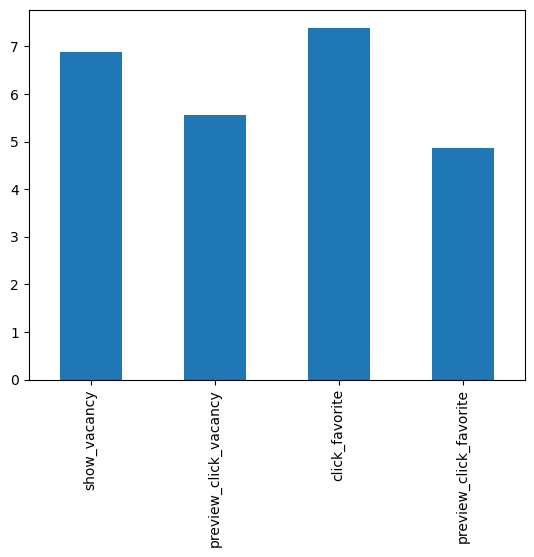

In [14]:
action_analysis_df['perc'].plot.bar();

Видим, что пользователи немного чаще совершали целевые действия после добавления в избранное со страницы вакансии, но в целом явной зависимости не видно. Можно считать, что гипотеза не подтвердилась 

In [15]:
# Выводим количество действий с вакансиями по дням

proc_train_df.groupby(['event_date'])['vacancy_id_'].value_counts()

event_date  vacancy_id_
2022-08-01  148714         1719
            108242         1706
            123270         1419
            258441         1274
            164602         1205
                           ... 
2022-10-01  259450            1
            259610            1
            259631            1
            259655            1
            260072            1
Name: vacancy_id_, Length: 1722031, dtype: int64

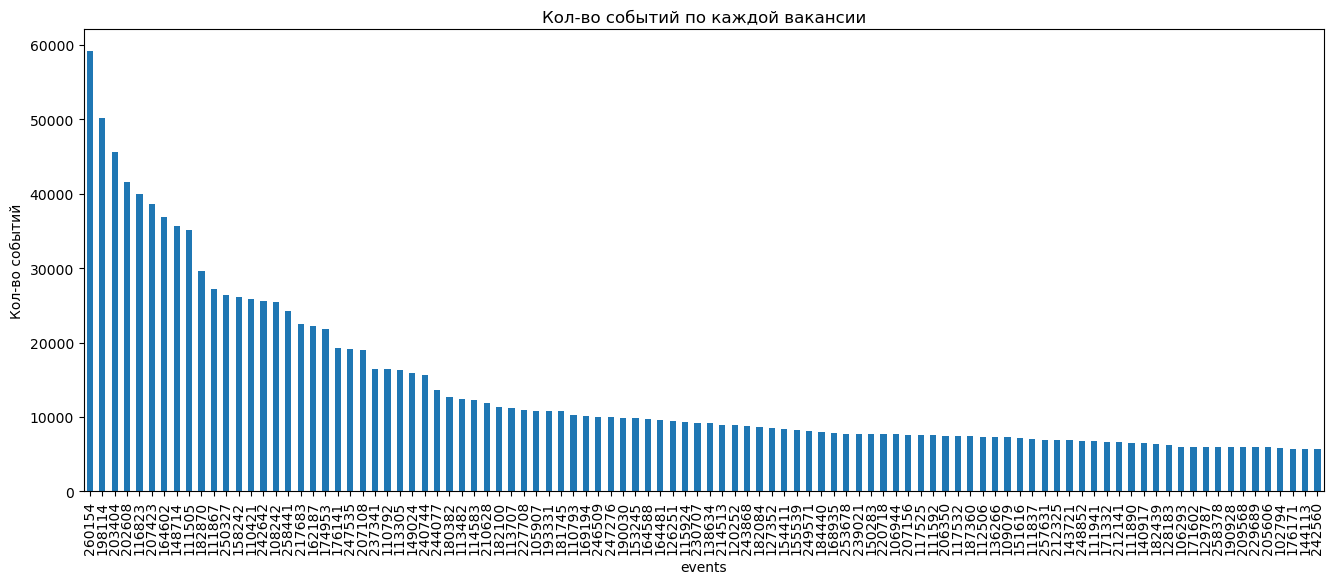

In [18]:
# Активность по вакансиям

vacancy_events = proc_train_df['vacancy_id_'].value_counts()
vacancy_events[:100].plot(
    kind='bar',
    figsize=(16, 6),
    title='Кол-во событий по каждой вакансии',
    xlabel='events',
    ylabel='Кол-во событий'
);

<b>260154</b> - самая популярная вакансия, кол-во действий за рассматриваемый период - 58670. На втором месте вакансия <b>198114</b> -  49907, на третьем вакансия <b>203404</b> - 45195.

---------

Выводим информацию о том, сколько времени потрачено на каждое событие

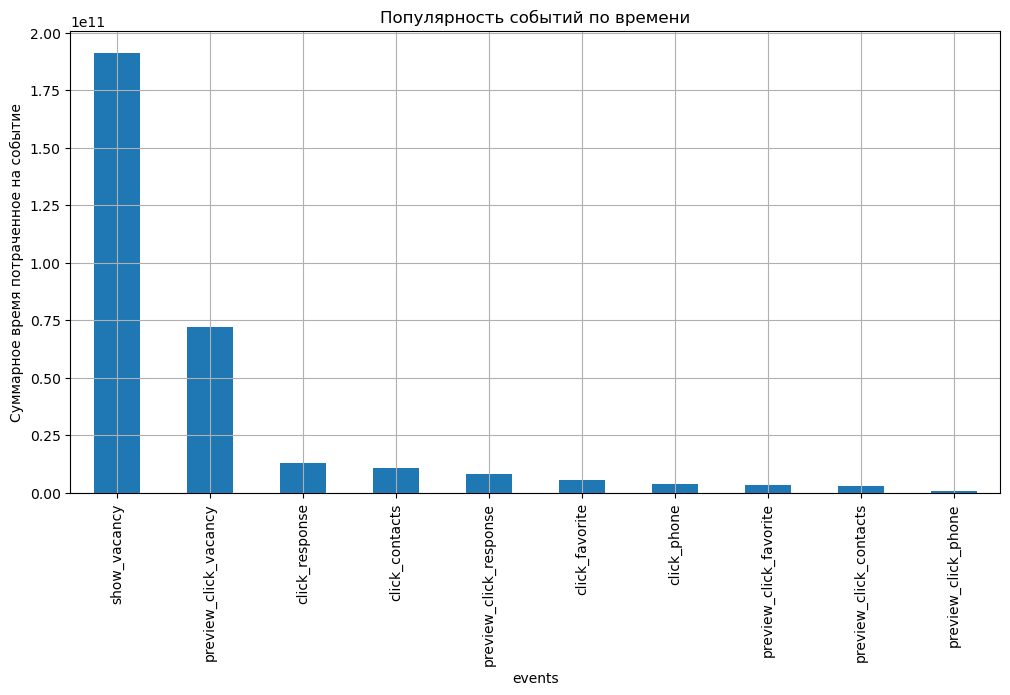

In [25]:
all_events_time = proc_train_df.groupby(['event_type'])['action_time'].sum().sort_values(ascending=False)
all_events_time.plot(
    kind='bar',
    figsize=(12, 6),
    title='Популярность событий по времени',
    xlabel='events',
    ylabel='Суммарное время потраченное на событие',
    grid = True,
);

<b>show_vacancy</b> - самое популярное действие на сайте, более 190.5 млд. секунд. На втором месте <b>preview_click_vacancy</b> более 71.6 млд. секунд.

-------------------------

Выводим информацию о распределении событий на платформе по дням, чтобы отыскать возможные аномалии в поведении

C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\1066445014.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  proc_train_df.groupby('event_date')['user_id', 'cookie_id'].nunique().plot(


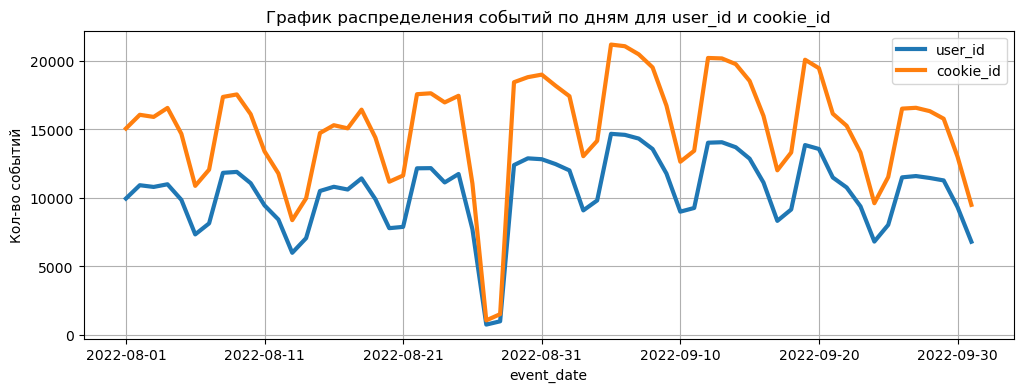

In [21]:
proc_train_df.groupby('event_date')['user_id', 'cookie_id'].nunique().plot(
    kind='line',
    figsize=(12, 4),
    title='График распределения событий по дням для user_id и cookie_id',
    ylabel='Кол-во событий',
    grid = True,
    lw=3
);
plt.legend(['user_id', 'cookie_id']);

In [22]:
proc_train_df.groupby('event_date')['user_id', 'cookie_id'].nunique().sort_values(by = 'user_id')

C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\3798075668.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  proc_train_df.groupby('event_date')['user_id', 'cookie_id'].nunique().sort_values(by = 'user_id')


,user_id,cookie_id
event_date,,
2022-08-27,726,1034
2022-08-28,966,1489
2022-08-13,5976,8365
2022-10-01,6786,9483
2022-09-24,6799,9604
...,...,...
2022-09-12,14029,20228
2022-09-13,14064,20194
2022-09-07,14331,20494


- В субботу <b>2022-08-27</b> числа и в воскресенье <b>2022-08-28</b> числа наблюдается снижение активности на платформе, что возможно говорит о каких-то проблемах.

Для подбора возможных "мешков" вакансий создаем несколько наборов топ вакансий по различным параметрам

**1. Рейтинг топ-100 вакансий по количеству действий по каждой неделе**

In [27]:
proc_train_df.groupby(['event_date', 'vacancy_id_']).agg({'event_type': ['count']}).reset_index()

,event_date,vacancy_id_,event_type
,,,count
0,2022-08-01,100004,3
1,2022-08-01,100006,8
2,2022-08-01,100015,2
3,2022-08-01,100018,2
4,2022-08-01,100021,2
...,...,...,...
1722026,2022-10-01,260143,2
1722027,2022-10-01,260150,2
1722028,2022-10-01,260154,669


In [28]:
# Группируем данные по столбцу 'event_date' и подсчитываем кол-во действий с вакансией в этот день

rating = proc_train_df.groupby(['event_date'])['vacancy_id_'].value_counts()
rating_df = pd.DataFrame(rating)

rating_df

vacancy_id_
event_date vacancy_id_             
2022-08-01 148714              1719
           108242              1706
           123270              1419
           258441              1274
           164602              1205
...                             ...
2022-10-01 259450                 1
           259610                 1
           259631                 1
           259655                 1
           260072                 1

[1722031 rows x 1 columns]

In [29]:
# Создаем новый столбец 'week' в который заносим номер недели

rating_df = rating_df.rename(columns={"vacancy_id_": "quantyti"})
rating_df = rating_df.reset_index()
rating_df['event_date'] = pd.to_datetime(rating_df['event_date'], errors ='coerce')
rating_df['week'] = rating_df['event_date'].dt.isocalendar().week

In [30]:
# Группируем датасет rating_df по полям 'week' и 'vacancy_id_' и подсчитываем кол-во действий с каждой вакансией в течении
# каждой недели. Всего 9 недель в датасете. Сортипуем по убыванию 'quantyti'

rating3 = rating_df.groupby(['week', 'vacancy_id_'])['quantyti'].sum().sort_values(ascending=False)
rating3_df = pd.DataFrame(rating3).reset_index()

In [31]:
# Формируем датасет ТОП 100 наибольшей активности по вакансиям на каждой неделе 

week_num = [32, 33, 34, 35, 36, 37, 38, 39]
df_week_top100 = rating3_df[rating3_df['week'] == 31][:100]
for i in week_num:    
    df_week = rating3_df[rating3_df['week'] == i][:100]
    df_week_top100 = df_week_top100.append(df_week, ignore_index = True )

C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\1924773751.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_week_top100 = df_week_top100.append(df_week, ignore_index = True )
C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\1924773751.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_week_top100 = df_week_top100.append(df_week, ignore_index = True )
C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\1924773751.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_week_top100 = df_week_top100.append(df_week, ignore_index = True )
C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\1924773751.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

In [32]:
df_week_top100

,week,vacancy_id_,quantyti
0,31,148714,11093
1,31,113707,10130
2,31,260154,7487
3,31,258441,7458
4,31,153245,7206
...,...,...,...
895,39,236860,660
896,39,240663,648
897,39,215913,644
898,39,237747,637


In [34]:
# В списки сохраним вакансии последней и предпоследней недель

week38 = df_week_top100[df_week_top100['week'] == 38]['vacancy_id_']. tolist ()
week39 = df_week_top100[df_week_top100['week'] == 39]['vacancy_id_']. tolist ()

In [35]:
# Найдем пересечение вакансий из двух списков

list_vacancy = []
for i in week38:
    if i in week39:
        list_vacancy.append(i)   

In [36]:
# 62 вакансии из ТОП 100 последней и предпоследней недель совпадают. 

len(list_vacancy)

62

**2. Количество вакансий, с которыми не было ни одного действия за последнюю неделю, 2 недели, 3 недели, 4 недели**

In [38]:
# Список всех вакансий

all_vacancy = proc_train_df['vacancy_id_']
all_vacancy = all_vacancy.drop_duplicates()
all_vacancy

15          192850
17          230581
19          250327
21          177451
23          108690
             ...  
12288391    256794
12291677    170777
12291708    185476
12291864    258908
12291919    233667
Name: vacancy_id_, Length: 160167, dtype: int64

In [39]:
# rating3_df - датасет со списками вакансий по неделям, кол-ом действий с этими вакансиями (от 1 до ...)
# Список вакансий за последнюю неделю
week_39 = rating3_df[rating3_df['week'] == 39]['vacancy_id_']. tolist ()
# Список вакансий за предпоследнюю неделю
week_38 = rating3_df[rating3_df['week'] == 38]['vacancy_id_']. tolist ()
# Список вакансий за 37 неделю
week_37 = rating3_df[rating3_df['week'] == 37]['vacancy_id_']. tolist ()
# Список вакансий за 36 неделю
week_36 = rating3_df[rating3_df['week'] == 36]['vacancy_id_']. tolist ()
print(f'last week = {len(week_39)}, week 38 = {len(week_38)}, week 37 = {len(week_37)}, week 36 = {len(week_36)}')

last week = 58534, week 38 = 66936, week 37 = 70514, week 36 = 71708


In [40]:
# Функция для поиска пересечений вакансий из двух списков
# чтобы выясеить со сколькими вакансиями не было никаках действий за последнюю неделю, 2, 3, 4
def list_intersection(week):
    lst = []
    for i in all_vacancy:
        if i not in week:
            lst.append(i)
    return lst

In [41]:
list_no_choosen_vacancy = {'last_week': 0, '2_last_weeks': 0, '3_last_weeks': 0, '4_last_weeks': 0}

In [42]:
list_no_choosen_vacancy['last_week'] = len(list_intersection(week_39))

In [43]:
list_no_choosen_vacancy['2_last_weeks'] = len(list_intersection(week_39 + week_38))

In [44]:
list_no_choosen_vacancy['3_last_weeks'] = len(list_intersection(week_39 + week_38 + week_37))

In [45]:
list_no_choosen_vacancy['4_last_weeks'] = len(list_intersection(week_39 + week_38 + week_37 + week_36))

In [46]:
list_no_choosen_vacancy

{'last_week': 101633,
 '2_last_weeks': 80766,
 '3_last_weeks': 64911,
 '4_last_weeks': 50245}

In [47]:
four_last_weeks = [101633, 80775, 64941, 50233]
lst_weeks = ['last_week', '2_last_weeks', '3_last_weeks', '4_last_weeks']

In [49]:
four_last_weeks_df = pd.DataFrame(list(list_no_choosen_vacancy.items()), columns=["x", "y"])
four_last_weeks_df

,x,y
0,last_week,101633
1,2_last_weeks,80766
2,3_last_weeks,64911
3,4_last_weeks,50245


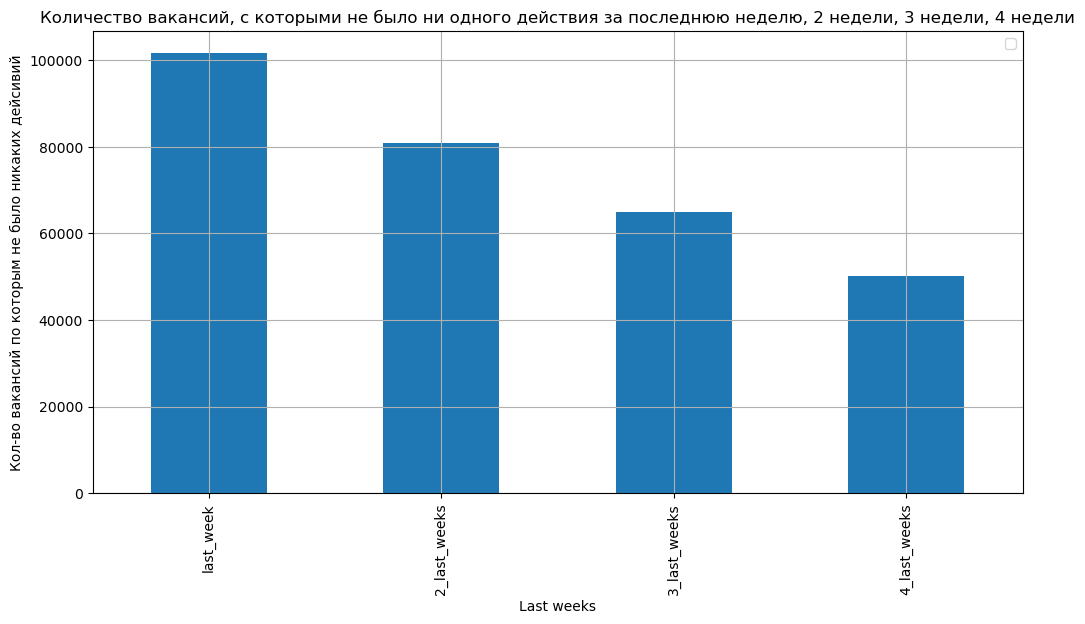

In [50]:
four_last_weeks_df.plot(
    kind='bar',
    x = 'x',
    y = 'y',
    figsize=(12, 6),
    title='Количество вакансий, с которыми не было ни одного действия за последнюю неделю, 2 недели, 3 недели, 4 недели',
    xlabel='Last weeks',
    ylabel='Кол-во вакансий по которым не было никаких дейсивий',
    grid = True,
);
plt.legend([])
plt.show()

In [51]:
# Выводим 4 датасета с id вакансий, для каждой из категорий (1, 2, 3, 4 недели)

list_no_choosen_vacancy_week_39 = list_intersection(week_39)
list_no_choosen_vacancy_week_39

In [52]:
df_no_choosen_vacancy_week_39 = pd.DataFrame(list_no_choosen_vacancy_week_39, columns=['last_week'])
df_no_choosen_vacancy_week_39

,last_week
0,177451
1,173832
2,169615
3,173741
4,135961
...,...
101628,256794
101629,170777
101630,185476
101631,258908


In [57]:
list_no_choosen_vacancy_week_39_38 = list_intersection(week_39 + week_38)

In [58]:
list_no_choosen_vacancy_week_39_38_37 = list_intersection(week_39 + week_38 + week_37)
df_no_choosen_vacancy_week_39_38_37 = pd.DataFrame(list_no_choosen_vacancy_week_39_38_37, columns=['last_3week'])
df_no_choosen_vacancy_week_39_38_37

,last_3week
0,138688
1,131347
2,120688
3,137749
4,121329
...,...
64906,175977
64907,256794
64908,170777
64909,185476


In [59]:
list_no_choosen_vacancy_week_39_38_37_36 = list_intersection(week_39 + week_38 + week_37 + week_36)
df_no_choosen_vacancy_week_39_38_37_36 = pd.DataFrame(list_no_choosen_vacancy_week_39_38_37_36, columns=['last_4week'])
df_no_choosen_vacancy_week_39_38_37_36

,last_4week
0,138688
1,120688
2,137749
3,121329
4,143093
...,...
50240,163843
50241,164064
50242,175977
50243,256794


**3. Для каждого cookie_id из private получаем дату последней активности.**

In [60]:
# Грузим тестовый датосет

test_df = pd.read_parquet(f"{data_folder}/test_private_users_mfti.parquet")
test_df

,cookie_id
0,0018914ba3e54011b28fa715583d3354
1,0035c298d8c64f368ae730a9cca9bb20
2,00956458877448ec9fba87fb97443fdf
3,0099387c921b41e7bae6c99dd8254b60
4,009f65e8ae99413a8da94a491320580a
...,...
3081,ffadd195859444d2ade2479b0611c5c1
3082,ffbc08b528c64f22996873fc63872202
3083,ffdeaf3c34544529880aebf17c103f6c
3084,ffefa79a74804ee69e6c131e0d05b948


In [61]:
proc_train_df['cookie_id'].nunique()

330180

In [62]:
# Объединяем (inner join) два датасета по полю 'cookie_id'

merged_test_train_cookie_df = proc_train_df.merge(test_df, left_on=['cookie_id'], right_on=['cookie_id'])
merged_test_train_cookie_df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,common_id_2,show_vacancy,preview_click_vacancy,click_favorite,preview_click_favorite
0,123,2022-09-21,1663752696,0.0,251009,0018914ba3e54011b28fa715583d3354,None,preview_click_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
1,123,2022-09-21,1663752696,47.0,251009,0018914ba3e54011b28fa715583d3354,None,show_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
2,123,2022-09-21,1663752743,0.0,225765,0018914ba3e54011b28fa715583d3354,None,preview_click_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
3,123,2022-09-21,1663752743,57.0,225765,0018914ba3e54011b28fa715583d3354,None,show_vacancy,0018914ba3e54011b28fa715583d3354,1,0,0,0
4,123,2022-09-21,1663752800,11366.0,225765,0018914ba3e54011b28fa715583d3354,None,click_response,0018914ba3e54011b28fa715583d3354,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344375,367569,2022-08-11,1660210724,22.0,185446,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,show_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
344376,367569,2022-08-11,1660210746,30.0,152871,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,show_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
344377,367569,2022-08-11,1660210776,197.0,159236,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,preview_click_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
344378,367569,2022-08-11,1660210973,170.0,255497,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,preview_click_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0


In [63]:
# Другой способ объединения двух датасетов

test_train_cookie_df = proc_train_df[proc_train_df['cookie_id'].isin(test_df['cookie_id'])]
test_train_cookie_df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,common_id_2,show_vacancy,preview_click_vacancy,click_favorite,preview_click_favorite
3745,123,2022-09-21,1663752696,0.0,251009,0018914ba3e54011b28fa715583d3354,None,preview_click_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
3746,123,2022-09-21,1663752696,47.0,251009,0018914ba3e54011b28fa715583d3354,None,show_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
3747,123,2022-09-21,1663752743,0.0,225765,0018914ba3e54011b28fa715583d3354,None,preview_click_vacancy,0018914ba3e54011b28fa715583d3354,0,0,0,0
3748,123,2022-09-21,1663752743,57.0,225765,0018914ba3e54011b28fa715583d3354,None,show_vacancy,0018914ba3e54011b28fa715583d3354,1,0,0,0
3749,123,2022-09-21,1663752800,11366.0,225765,0018914ba3e54011b28fa715583d3354,None,click_response,0018914ba3e54011b28fa715583d3354,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12290116,367569,2022-08-11,1660210724,22.0,185446,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,show_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
12290117,367569,2022-08-11,1660210746,30.0,152871,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,show_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
12290118,367569,2022-08-11,1660210776,197.0,159236,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,preview_click_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0
12290119,367569,2022-08-11,1660210973,170.0,255497,fff0c04c0cd54c67bb5fd79ae7b1145b,8ecdbd1be53b467498f7384640be70e1,preview_click_vacancy,8ecdbd1be53b467498f7384640be70e1,0,0,0,0


In [64]:
# Группипуем получившийся датасет по cookie_id где в поле 'event_date' вносим последнюю дату активности

test_train_cookie = test_train_cookie_df.groupby(['cookie_id'])['event_date'].max()
test_train_cookie_df2 = pd.DataFrame(test_train_cookie).reset_index()
test_train_cookie_df2

,cookie_id,event_date
0,0018914ba3e54011b28fa715583d3354,2022-09-24
1,0035c298d8c64f368ae730a9cca9bb20,2022-09-13
2,00956458877448ec9fba87fb97443fdf,2022-09-24
3,0099387c921b41e7bae6c99dd8254b60,2022-09-29
4,009f65e8ae99413a8da94a491320580a,2022-09-29
...,...,...
3081,ffadd195859444d2ade2479b0611c5c1,2022-09-02
3082,ffbc08b528c64f22996873fc63872202,2022-09-29
3083,ffdeaf3c34544529880aebf17c103f6c,2022-09-16
3084,ffefa79a74804ee69e6c131e0d05b948,2022-09-23


In [65]:
test_train_cookie

cookie_id
0018914ba3e54011b28fa715583d3354    2022-09-24
0035c298d8c64f368ae730a9cca9bb20    2022-09-13
00956458877448ec9fba87fb97443fdf    2022-09-24
0099387c921b41e7bae6c99dd8254b60    2022-09-29
009f65e8ae99413a8da94a491320580a    2022-09-29
                                       ...    
ffadd195859444d2ade2479b0611c5c1    2022-09-02
ffbc08b528c64f22996873fc63872202    2022-09-29
ffdeaf3c34544529880aebf17c103f6c    2022-09-16
ffefa79a74804ee69e6c131e0d05b948    2022-09-23
fff0c04c0cd54c67bb5fd79ae7b1145b    2022-08-11
Name: event_date, Length: 3086, dtype: object

**4. Строим графики с временем, которое пользователь тратит на любое из нецелевых действий, прежде чем сделать целевое и с количеством таких целевых действий для каждого времени**

In [66]:
#Создаем список уникальных событий

qw = proc_train_df['event_type'].value_counts()
events = qw.index.to_list()
events

['show_vacancy',
 'preview_click_vacancy',
 'click_response',
 'click_contacts',
 'preview_click_response',
 'click_favorite',
 'preview_click_favorite',
 'preview_click_contacts',
 'click_phone',
 'preview_click_phone']

In [67]:
features_events = ['show_vacancy', 'preview_click_vacancy', 'click_favorite', 'preview_click_favorite']
features_events

['show_vacancy',
 'preview_click_vacancy',
 'click_favorite',
 'preview_click_favorite']

In [68]:
# Целевые события

target_events = ['click_response', 'click_contacts', 'preview_click_response', 'preview_click_contacts',
                 'click_phone', 'preview_click_phone']
target_events

['click_response',
 'click_contacts',
 'preview_click_response',
 'preview_click_contacts',
 'click_phone',
 'preview_click_phone']

In [69]:
df = proc_train_df.copy()

# Скопируем в новый столюец 'not_target_event' нецелевые события
df['not_target_event'] = np.where(df['event_type'].isin(features_events), df['event_type'], 0)

# В новый столбец 'target_event' целевые события отметим 1, нецелевые 0
df['target_event'] = np.where(df['event_type'].isin(target_events), 1, 0)

# В столбец 'nonrel_action_time' скопируем время потраченное на нецелевые действия
df['nonrel_action_time'] = np.where(df['event_type'].isin(features_events), df['action_time'], 0)
df['rel_action_time'] = np.where(df['event_type'].isin(target_events), df['action_time'], 0)

In [70]:
# Создаем датафрейм со списками нецелевых действий пользователя по вакансиям

not_target = df.groupby(['common_id', 'vacancy_id_'])['not_target_event'].apply(list)
not_target_df = pd.DataFrame(not_target)

In [71]:
# Создаем датафрейм со списками целевых действий пользователя по вакансиям

target = df.groupby(['common_id', 'vacancy_id_'])['target_event'].apply(list)
target_df = pd.DataFrame(target)

In [72]:
# Соединяем два датафрейма в один

merged_df = not_target_df.merge(target_df,
                                left_on=['common_id', 'vacancy_id_'],
                                right_on=['common_id', 'vacancy_id_'])

In [73]:
# Создаем датафрейм со временем потраченным пользователем на нецелеыве действмя по вакансиям

sec = df.groupby(['common_id', 'vacancy_id_'])['nonrel_action_time'].sum()
sec_df = pd.DataFrame(sec)

In [74]:
# Создаем датафрейм со временем потраченным пользователем на целеыве действмя по вакансиям

sec2 = df.groupby(['common_id', 'vacancy_id_'])['rel_action_time'].sum()
sec2_df = pd.DataFrame(sec2)

In [75]:
# Объединяем события и время потраченное на нецелеыве события по common_id и vacancy_id_

merged_df = merged_df.merge(sec_df,
                            left_on=['common_id', 'vacancy_id_'],
                            right_on=['common_id', 'vacancy_id_'])

In [76]:
# Объединяем события и время потраченное на целеыве события по common_id и vacancy_id_

merged_df = merged_df.merge(sec2_df,
                            left_on=['common_id', 'vacancy_id_'],
                            right_on=['common_id', 'vacancy_id_'])

In [78]:
final_df = merged_df.copy()

In [79]:
# Получаем список списков действий клиентов по вакансиям. 1 - целевое действие, 0 - нецелевае

llst = []
llst = final_df['target_event'].to_list()

In [80]:
# Собираем вектор по вакансиям 1 - хотя бы одно действие было целевае, 0 - действия нецелевые

target_lst = []
temp = 0
for i in llst:
    temp = 0
    for j in i:
        if j == 1:
            temp = 1
    target_lst.append(temp)

In [81]:
# Преобразуем в датафрейм

target_df = pd.DataFrame(target_lst, columns = ['target_event'])
target_df.index.name = "index"

In [82]:
final_df['new'] = final_df.index

In [83]:
final_df = final_df.reset_index()
final_df.index.name = "index"

# Добавляем к final_df датасет target_df
final_df = final_df.merge(target_df, left_on=['index'], right_on=['index'])

In [84]:
lsd2 = final_df.drop(columns = ['not_target_event', 'rel_action_time', 'common_id', 'vacancy_id_', 'new', 'target_event_x'])

#Группируем по времени которое было потрачено прежде чем произошло целевое событое 
lsd1 = lsd2.where(lsd2['target_event_y']==1).groupby(['nonrel_action_time']).count()

#Группируем по времени которое было потрачено, но целевое событое не произошло
lsd0 = lsd2.where(lsd2['target_event_y']==0).groupby(['nonrel_action_time']).count()

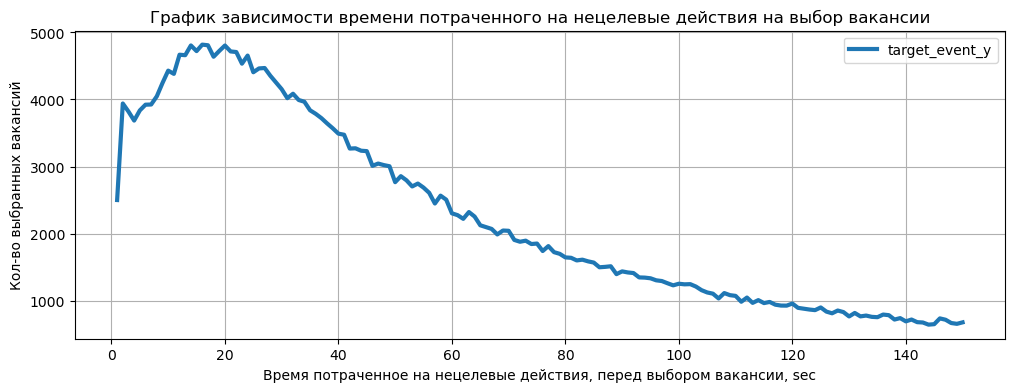

In [85]:
import matplotlib.pyplot as plt
lsd1[1:150].plot(
    kind='line',
    figsize=(12, 4),
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии',
    xlabel='Время потраченное на нецелевые действия, перед выбором вакансии, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);

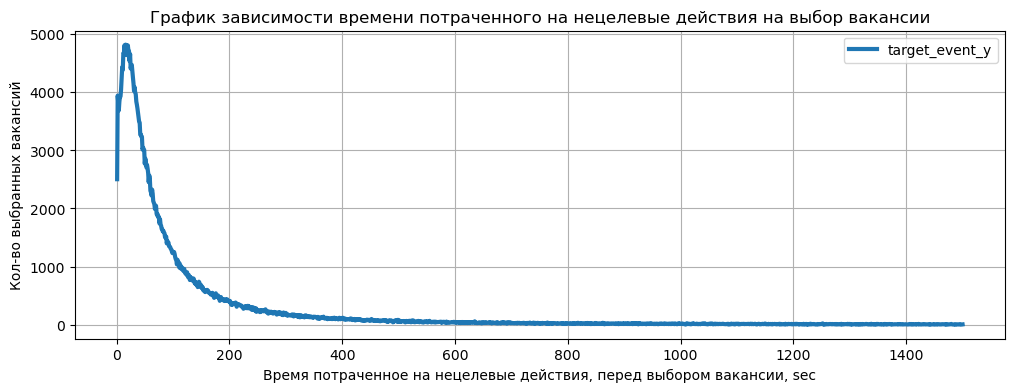

In [86]:
lsd1[1:1500].plot(
    kind='line',
    figsize=(12, 4),
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии',
    xlabel='Время потраченное на нецелевые действия, перед выбором вакансии, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);

 --------------------------- 
  - <b>225721</b> раз пользователи выполнили целевое действие (выбрали вакансию) без предварительного просмотра, т.е. потратили 0 сек на предварительный просмотр. 
Далее наблюдается резкий провал до 2470 целевых действий, если пользователи тратили 1 сек на нецелевые действия, а потом количество целевых действий растет с ростом времени потраченного на просмотр вакансии. Локальный пик примерно 4800 целевых действий в районе 18 - 20 сек. В дальнейшем, чем больше пользователь тратит времени на нецелевые действия, тем меньше шанс, что будет сделан выбор. После 500 сек кол-во целевых действий стремится к 1. 



----------------------

**5. Строим графики со временем, которое пользователь тратит на любое из нецелевых действий, прежде чем сделать целевое и с количеством таких целевых действий для каждого времени для случаев, когда целевое действие следует за 'show_vacancy'**

In [87]:
show_vacancy_df = final_df[final_df['target_event_y'] == 1]

In [88]:
sv_lst = ['show_vacancy', ]
show_vacancy_df['show_vacancy'] = show_vacancy_df.apply(lambda x :(1 if ('show_vacancy' in x['not_target_event']) & (0 in x['not_target_event'])  else 0) , axis=1)

C:\Users\Yury\AppData\Local\Temp\ipykernel_10308\344604603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_vacancy_df['show_vacancy'] = show_vacancy_df.apply(lambda x :(1 if ('show_vacancy' in x['not_target_event']) & (0 in x['not_target_event'])  else 0) , axis=1)


In [89]:
show_vacancy_df = show_vacancy_df[show_vacancy_df['show_vacancy'] == 1]

In [90]:
final_df = final_df.drop(columns=['target_event_x', 'new'])
final_df[25:100]

,common_id,vacancy_id_,not_target_event,nonrel_action_time,rel_action_time,target_event_y
index,,,,,,
25,3,251362,"[preview_click_vacancy, show_vacancy, 0, show_...",381.0,17.0,1
26,4,135961,[show_vacancy],102.0,0.0,0
27,4,138502,[show_vacancy],31.0,0.0,0
28,4,138688,"[show_vacancy, 0, show_vacancy, show_vacancy]",107.0,3.0,1
29,4,209629,"[preview_click_vacancy, show_vacancy]",572002.0,0.0,0
...,...,...,...,...,...,...
95,8,256310,"[preview_click_vacancy, show_vacancy]",71.0,0.0,0
96,8,260154,"[preview_click_vacancy, show_vacancy]",381.0,0.0,0
97,9,129498,"[preview_click_vacancy, show_vacancy]",118.0,0.0,0


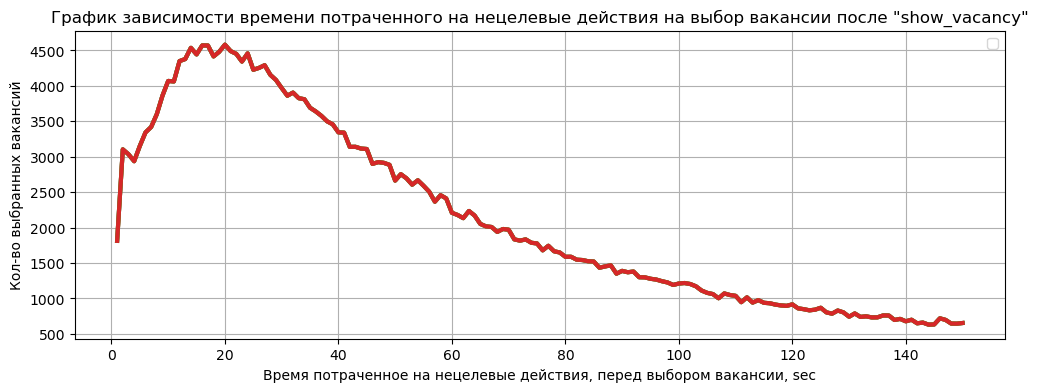

In [91]:
show_vacancy2 = show_vacancy_df.drop(columns = ['target_event_y', 'not_target_event', 'common_id', 'vacancy_id_'])

#Группируем по времени которое было потрачено прежде чем произошло целевое событое 
show_vacancy1 = show_vacancy2.groupby(['nonrel_action_time']).count()

show_vacancy1[1:150].plot(
    kind='line',
    figsize=(12, 4),
   # x = ['nonrel_action_time'],
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии после "show_vacancy"',
    xlabel='Время потраченное на нецелевые действия, перед выбором вакансии, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);
plt.legend([])

In [92]:
show_vacancy1.head(20).T

nonrel_action_time,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
target_event_x,2687,1812,3102,3033,2935,3150,3341,3418,3600,3861,4067,4060,4347,4376,4534,4441,4568,4567,4413,4479
rel_action_time,2687,1812,3102,3033,2935,3150,3341,3418,3600,3861,4067,4060,4347,4376,4534,4441,4568,4567,4413,4479
new,2687,1812,3102,3033,2935,3150,3341,3418,3600,3861,4067,4060,4347,4376,4534,4441,4568,4567,4413,4479
show_vacancy,2687,1812,3102,3033,2935,3150,3341,3418,3600,3861,4067,4060,4347,4376,4534,4441,4568,4567,4413,4479


## Aналогичный график с распределением времени для каждого из целевых действий

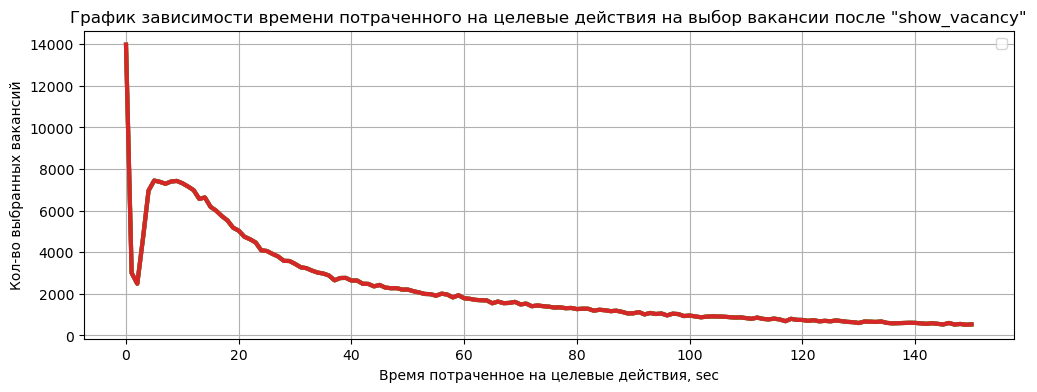

In [93]:
#Группируем по времени которое было потрачено прежде чем произошло целевое событое 
show_vacancy3 = show_vacancy2.groupby(['rel_action_time']).count()

show_vacancy3[0:150].plot(
    kind='line',
    figsize=(12, 4),
    title='График зависимости времени потраченного на целевые действия на выбор вакансии после "show_vacancy"',
    xlabel='Время потраченное на целевые действия, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);
plt.legend([])

**6. Зависимость выбора вакансий от времени потраченного на нецелевые действия**

In [95]:
final_df.groupby(['vacancy_id_'])['nonrel_action_time'].sum().sort_values(ascending=False)

vacancy_id_
260154    1.827179e+09
110421    1.142698e+09
148714    9.321926e+08
116823    9.229542e+08
202608    8.466324e+08
              ...     
166437    0.000000e+00
246472    0.000000e+00
166431    0.000000e+00
130682    0.000000e+00
180084    0.000000e+00
Name: nonrel_action_time, Length: 160167, dtype: float64


<b>260154</b> - самая популярная вакансия по времени нецелевых действий - 1812888746 сек. На втором месте вакансия <b>110421</b> - 1138892958, на третьем вакансия <b>148714</b> - 930109973.

--------------

In [96]:
# Сколько раз выбрали вакансию

cf = final_df.where(final_df['target_event_y']==1).groupby(['vacancy_id_'])['target_event_y'].count().sort_values(ascending=False)
cf_df = pd.DataFrame(cf)
cf_df

,target_event_y
vacancy_id_,
116823.0,5055
207423.0,3919
182870.0,3671
198114.0,3289
174953.0,3122
...,...
215059.0,1
121440.0,1
121436.0,1


In [97]:
# Сколько всего времени потрачено на выбранные вакансии
ctime = final_df.where(final_df['target_event_y']==1).groupby(['vacancy_id_'])['nonrel_action_time'].sum().sort_values(ascending=False)
ctime_df = pd.DataFrame(ctime)

# Создадим колонку в которой введем нормадизованние время, чтобы посмотреть на графике
ctime_df['norm_action_time'] = ctime_df.nonrel_action_time / 36000 
ctime_df

,nonrel_action_time,norm_action_time
vacancy_id_,,
116823.0,317705721.0,8825.158917
110421.0,195608577.0,5433.571583
260154.0,189483580.0,5263.432778
182870.0,173676823.0,4824.356194
198114.0,141222389.0,3922.844139
...,...,...
185910.0,0.0,0.000000
223763.0,0.0,0.000000
185928.0,0.0,0.000000


In [98]:
# Добавим к датафрейму cf_df_merge кобонку target_event_y

cf_df_merge = cf_df.merge(ctime_df, left_on=['vacancy_id_'], right_on=['vacancy_id_'])
cf_df_merge = cf_df_merge.reset_index()
cf_df_merge.index.name = "index"
cf_df_merge['vacancy_id_'] = cf_df_merge['vacancy_id_'].astype(int)
cf_df_merge

,vacancy_id_,target_event_y,nonrel_action_time,norm_action_time
index,,,,
0,116823,5055,317705721.0,8825.158917
1,207423,3919,92780458.0,2577.234944
2,182870,3671,173676823.0,4824.356194
3,198114,3289,141222389.0,3922.844139
4,174953,3122,133043854.0,3695.662611
...,...,...,...,...
121031,215059,1,302.0,0.008389
121032,121440,1,52.0,0.001444
121033,121436,1,80761.0,2.243361


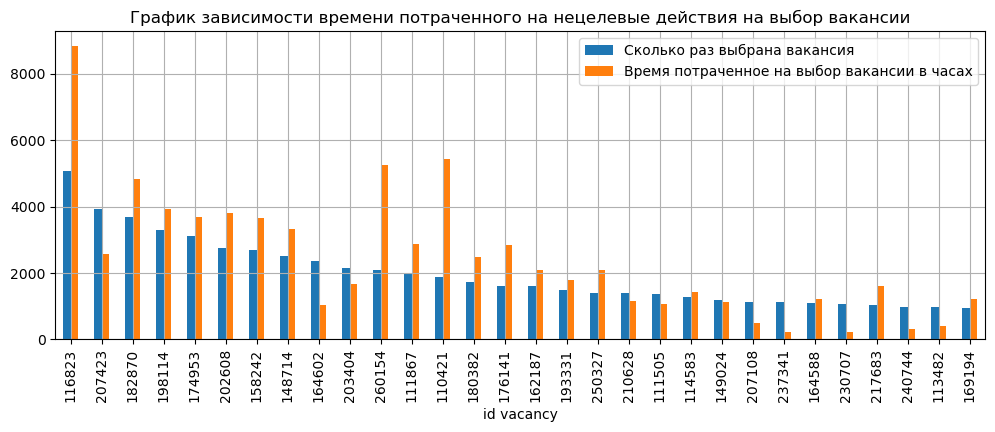

In [99]:
test_df = cf_df_merge.nlargest(30, ['target_event_y'])
test_df.plot(
    kind='bar',
    figsize=(12, 4),
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии',
    x = 'vacancy_id_',
    y = ['target_event_y', 'norm_action_time'],
    grid = True,
    lw=3
)
plt.legend(['Сколько раз выбрана вакансия', 'Время потраченное на выбор вакансии в часах'])
plt.xlabel('id vacancy')
plt.ylabel('')
plt.show()

In [100]:
cf_df_merge.describe()

,vacancy_id_,target_event_y,nonrel_action_time,norm_action_time
count,121036.000000,121036.000000,1.210360e+05,121036.000000
mean,180405.095063,6.138744,2.024135e+05,5.622598
std,45736.445835,39.341362,1.939165e+06,53.865701
min,100001.000000,1.000000,0.000000e+00,0.000000
25%,141549.750000,1.000000,1.000000e+00,0.000028
50%,180849.500000,2.000000,1.430000e+02,0.003972
75%,219279.500000,5.000000,1.091050e+04,0.303069
max,260167.000000,5055.000000,3.177057e+08,8825.158917


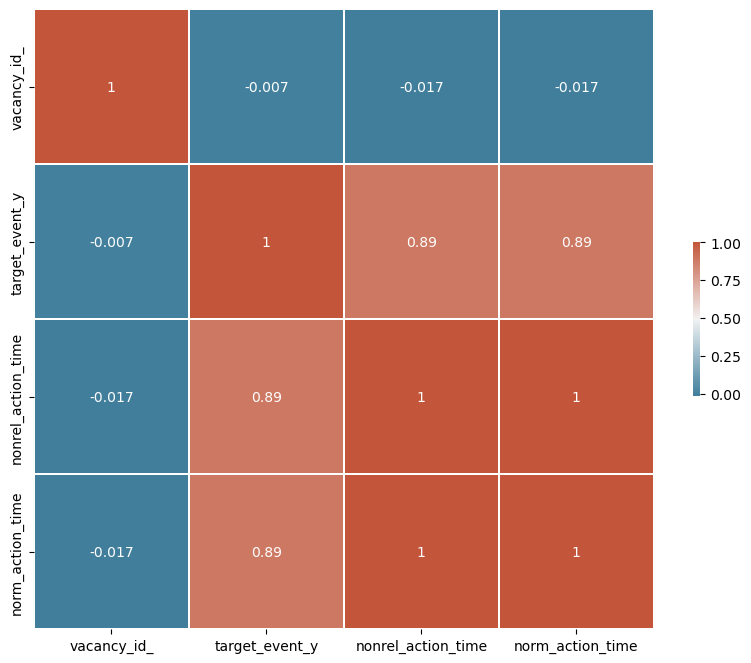

In [101]:
import seaborn as sns
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    cf_df_merge.corr(),  annot=True, cmap=cmap,
    square=True, linewidths=.2, cbar_kws={"shrink": .2}
);

Наблюдается корреляция целевых действий и времени потраченного на нецелевые действия.


--------------------------

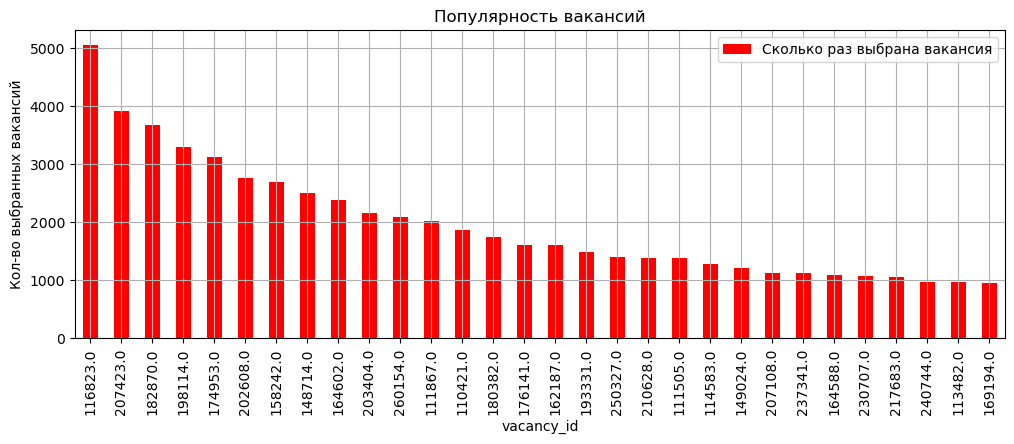

In [102]:
grouped_cf_df = cf_df.nlargest(30, ['target_event_y'])
grouped_cf_df.plot(
    kind='bar',
    color = 'red',
   # bins=100,
    figsize=(12, 4),
    title='Популярность вакансий',
    xlabel='vacancy_id',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
);
plt.legend(['Сколько раз выбрана вакансия']);

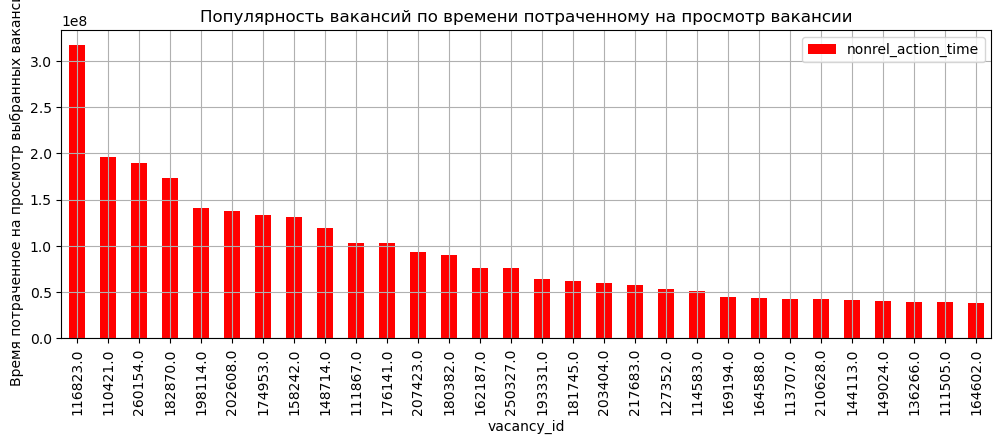

In [103]:
grouped_ctime_df = ctime_df.nlargest(30, ['nonrel_action_time'])
grouped_ctime_df = grouped_ctime_df.drop(columns=['norm_action_time'])
grouped_ctime_df.plot(
    kind='bar',
    color = 'red',
   # bins=100,
    figsize=(12, 4),
    title='Популярность вакансий по времени потраченному на просмотр вакансии',
    xlabel='vacancy_id',
    ylabel='Время потраченное на просмотр выбранных вакансий',
    grid = True,
);

**7. Количество уникальных пользователей, целевых и нецелевых действий по дням недели. и доля целевых действий в общем количестве действий по дням недели**

In [106]:
# Создаем новый столбец 'day_of_week' в который заносим день недели
df['event_date'] = pd.to_datetime(df['event_date'])
df['day_of_week'] = df['event_date'].dt.day_name()

# Группируем по дням недели
day_of_week_events = df.groupby(['day_of_week'])['target_event'].value_counts()

In [107]:
day_of_week_events = day_of_week_events.to_frame (name='values')
day_of_week_events = day_of_week_events.loc[[(   'Monday', 0),(   'Monday', 1),
           (  'Tuesday', 0),(  'Tuesday', 1),
           ('Wednesday', 0),('Wednesday', 1),
           ( 'Thursday', 0),( 'Thursday', 1),
           (   'Friday', 0),(   'Friday', 1),
           ( 'Saturday', 0),( 'Saturday', 1),
           (   'Sunday', 0),(   'Sunday', 1),]]
day_of_week_events

values
day_of_week target_event         
Monday      0             1978954
            1              174294
Tuesday     0             1980935
            1              190424
Wednesday   0             1882729
            1              178799
Thursday    0             1801141
            1              175736
Friday      0             1487870
            1              147537
Saturday    0             1052058
            1               88918
Sunday      0             1059342
            1               93851

In [108]:
day_of_week_events = day_of_week_events.reset_index()
day_of_week_events.index.name = "index"
day_of_week_events['all_events'] = 0
day_of_week_events['percent_of_events'] = 0

# Заносим в столбец 'all_events' сумму всех событий по дням недели,
# а в столбец 'percent_of_events' долю целевых и добю нецелевых действий

for i, row in day_of_week_events.iterrows():
    if i % 2 == 0:
        a = day_of_week_events.iloc[[i], [2]].values[0][0] + day_of_week_events.iloc[[i+1], [2]].values[0][0]
        day_of_week_events.iloc[[i], [3]] = a
        day_of_week_events.iloc[[i], [4]] = day_of_week_events.iloc[[i], [2]].values[0][0] / a * 100
    else:
        day_of_week_events.iloc[[i], [3]] = a
        day_of_week_events.iloc[[i], [4]] = day_of_week_events.iloc[[i], [2]].values[0][0] / a * 100

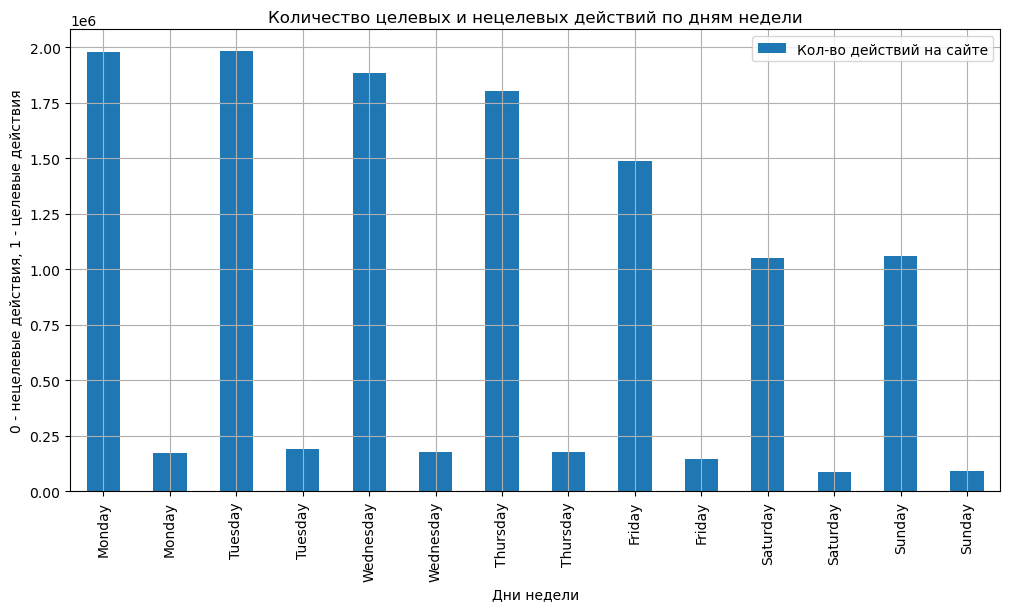

In [109]:
#test_df = cf_df_merge.nlargest(30, ['target_event_y'])
day_of_week_events.plot(
    kind='bar',
    figsize=(12, 6),
    title='Количество целевых и нецелевых действий по дням недели',
    y = ['values'],
    x = 'day_of_week',
    grid = True,
    lw=3
)
plt.legend(['Кол-во действий на сайте', 'Процент от всех действий'])
plt.xlabel('Дни недели')
plt.ylabel('0 - нецелевые действия, 1 - целевые действия')
plt.xticks = 'percent_of_events'
plt.show();

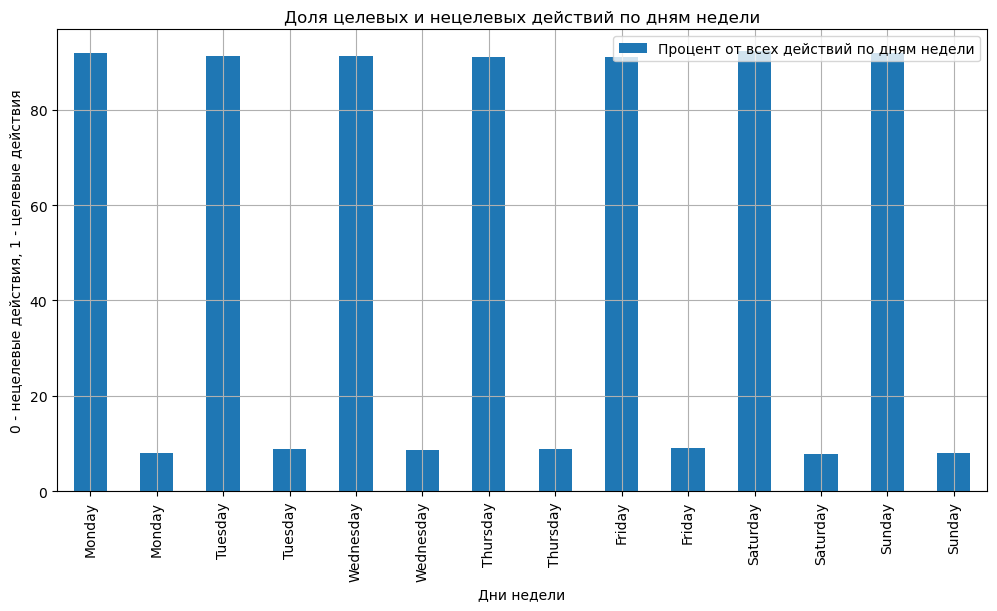

In [110]:
day_of_week_events.plot(
    kind='bar',
    figsize=(12, 6),
    title='Доля целевых и нецелевых действий по дням недели',
    y = ['percent_of_events'],
    x = 'day_of_week',
    grid = True,
    lw=3
)
plt.legend(['Процент от всех действий по дням недели'])
plt.xlabel('Дни недели')
plt.ylabel('0 - нецелевые действия, 1 - целевые действия')
plt.xticks = 'percent_of_events'
plt.show();

**test_public_mfti.parquet** – часть теста, с открытым таргетом, для проверки работоспособности решений.

* cookie_id - id пользователя по его браузеру/ip/устройству
* vacancy_id_ - список вакансий, на которые пользователь откликнулся или позвонил в течение месяца после окончания данных train

In [64]:
test_public_mfti_df = pd.read_parquet('Data_Rabota/test_public_mfti.parquet', engine='pyarrow')
test_public_mfti_df

,cookie_id,vacancy_id_
0,000cd76cd33f43d4a1ac1d16d10f8bf7,"[222177, 222173, 222163, 238874, 238878, 22812..."
1,0034bc7f404341ba8412665453e7825a,"[102794, 137587, 257319, 237756, 240744, 11348..."
2,00a6c5a64a274c55a836402bdeb3b2c4,"[254292, 164602, 116438, 228634, 218819, 24065..."
3,015937a125b14e74bdff1cddc49f9172,"[246685, 138123, 115420, 210628, 212325, 235196]"
4,01de50c280794cec8804f16f45f847b7,"[219070, 251469, 166899, 212703, 214561]"
...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[207851, 254989, 213344, 214180, 222146]"
768,fe6193ab26494ace9be5aae36e507618,"[115352, 230546, 225527, 120188, 109360, 23212..."
769,fe95b2826ee1452b81201ed3f4c3294d,"[240362, 114852, 253946, 251081, 127546, 244688]"
770,ff1aef256a49481698bb2e938510ff36,"[231194, 236363, 220747, 244688, 100094, 24052..."


In [65]:
# Выводим общую информацию, делаем вывод, что пропущенных значений нет

test_public_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cookie_id    772 non-null    object
 1   vacancy_id_  772 non-null    object
dtypes: object(2)
memory usage: 12.2+ KB


**test_private_users_mfti.parquet** – часть теста, с закрытым таргетом для итоговой проверки решений

* cookie_id - id пользователя по его браузеру/ip/устройству

In [23]:
test_private_users_mfti_df = pd.read_parquet('Data_Rabota/test_private_users_mfti.parquet', engine='pyarrow')
test_private_users_mfti_df

,cookie_id
0,0018914ba3e54011b28fa715583d3354
1,0035c298d8c64f368ae730a9cca9bb20
2,00956458877448ec9fba87fb97443fdf
3,0099387c921b41e7bae6c99dd8254b60
4,009f65e8ae99413a8da94a491320580a
...,...
3081,ffadd195859444d2ade2479b0611c5c1
3082,ffbc08b528c64f22996873fc63872202
3083,ffdeaf3c34544529880aebf17c103f6c
3084,ffefa79a74804ee69e6c131e0d05b948


In [24]:
# Выводим общую информацию, делаем вывод, что пропущенных значений нет

test_private_users_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cookie_id  3086 non-null   object
dtypes: object(1)
memory usage: 24.2+ KB
